A non-parametric version of the form of (5) can be constructed using $\mathbf{\rho}$ to complement the input space, i.e.,

$$
f_\mathcal{P}(\mathbf{x}|\mathbf{c})=f_\mathcal{G}(\mathbf{z}|\mathbf{c}) = \sum_{i=1}^{n}c_i G(\mathbf{\rho}(\mathbf{x})-\mathbf{\rho}(\mathbf{x}_i))G(\mathbf{x}-\mathbf{x}_i)
$$

where $\mathbf{z}=(\mathbf{x}^T, \mathbf{\rho}(\mathbf{x})^T)^T$. This weighted kernel formulation introduces physical-relevance into the PBLM while utilizing the advantages of localized non-parametric regression. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

In [2]:
beta = 3
omega = 8*np.pi
alpha = 1
phi = 0.15*np.pi

def f(t):
    return alpha*np.tanh(beta*t)*np.sin(omega*t + phi)

var = np.var(f(np.linspace(0, 1, 1000)))

def noisy_f(x, percent=0.1):
    f_x = f(x)
    v = (percent**2*var)
    np.random.seed(4)
    return f(x)+np.random.normal(0, scale=v, size=x.shape)

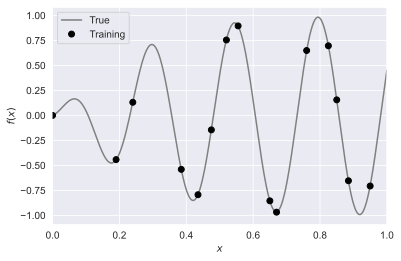

In [32]:
np.random.seed(5)
N = 15
X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_test = f(X_test)[:, 0]
X_train = np.array([0, 0.19, 0.24, 0.385, 0.435, 0.475, 0.52, 0.555, 0.65, 0.67, 0.76, 0.825, 0.85, 0.885, 0.95])#np.random.uniform(0, 1, N).reshape(-1, 1)#np.linspace(0, np.pi, 10, 'o').reshape(-1, 1)
X_train = np.atleast_2d(X_train).T
y_train = noisy_f(X_train)[:, 0]

fig, ax = plt.subplots()
ax.plot(X_test, y_test, c='grey', linestyle='-', label="True")
ax.plot(X_train, y_train, 'ko', label='Training', zorder=3)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_xlim(0, 1)
ax.legend()

In [33]:
def IM(X):
    return X*np.sin(omega*X)

def finite_difference(X, delta=0.01):
        f_x = IM(X)
        f_pdx = IM(X+delta)
        f_ndx = IM(X-delta)
        return np.hstack((f_x, f_pdx, f_ndx))

In [34]:
Phi_generator(X_train).shape

(15, 4)

In [35]:
X_train.shape

(15, 1)

In [36]:
def gaussian_kernel(x, xi, sigma=1):
    """
    The gaussian kernel G(x-xi) = (1/(sqrt(2pi)*sigma))*e^(-0.5||x||^2)
    """
    x = np.atleast_2d(x)
    xi = np.atleast_2d(xi)
    sq_norm = -0.5 * spatial.distance.cdist(x, xi, 'sqeuclidean')
    return np.exp(sq_norm/sigma**2)

In [37]:
tmp = finite_difference(X_train)

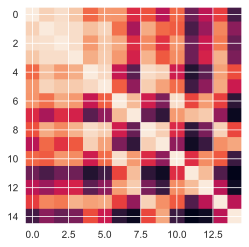

In [19]:
K_rho = gaussian_kernel(tmp, tmp)
K_x = gaussian_kernel(X_train, X_train)
K_comb = K_rho * K_x
plt.imshow(K_comb)

In [20]:
duel_variables = np.linalg.solve(K_comb, y_train)

In [23]:
rho_pred = finite_difference(X_test)
K_rho_pred = gaussian_kernel(rho_pred, tmp)
K_x_pred = gaussian_kernel(X_test, X_train)
K_pred = K_rho_pred * K_x_pred
y_pred = np.dot(K_pred, duel_variables)

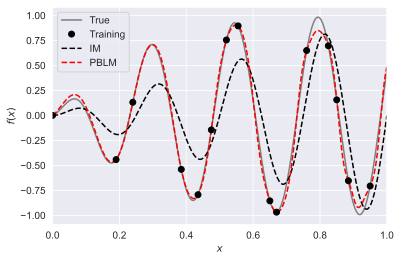

In [26]:
fig, ax = plt.subplots()
ax.plot(X_test, y_test, c='grey', linestyle='-', label="True")
ax.plot(X_train, y_train, 'ko', label='Training', zorder=3)
ax.plot(X_test, IM(X_test), 'k--', label='IM')
ax.plot(X_test, y_pred, 'r--', label='PBLM', zorder=2)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_xlim(0, 1)
ax.legend()

(-1.5, 1.5)

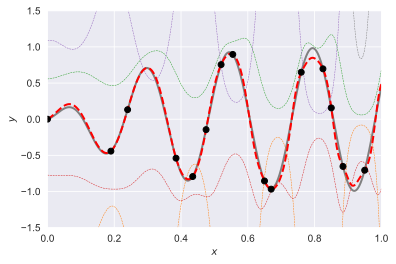

In [30]:
fig, ax = plt.subplots()
f_g = []
ax.plot(X_test, y_test, c='grey', linestyle='-', linewidth=2, label="True")
ax.plot(X_train, y_train, 'ko', label='Training', zorder=3)
for i, (x_i, c_i) in enumerate(zip(X_train.ravel(), duel_variables.ravel())):
    x = np.linspace(0, 1, 1000).reshape(-1, 1)
    rho = finite_difference(x)
    rho_i = finite_difference(x_i)
    g_x = c_i*gaussian_kernel(rho_pred, rho_i)*gaussian_kernel(x, x_i)
    f_g += [g_x]
    ax.plot(x, g_x, linestyle='--', linewidth=.5, label=f'$x_{{{i}}}$')
ax.plot(x, np.sum(f_g, axis=0), 'r--', linewidth=2, label=r'KRR')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim(0, 1)
ax.set_ylim(-1.5, 1.5)